# Fitness AI

In [1]:
import cv2
import math
import mediapipe as mp

In [2]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

## Pose Detection

In [3]:
def detectPose(image, pose, display=True):
    output_image = image.copy()
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(imageRGB)

    height, width, _ = image.shape
    
    landmarks = []
    
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

## Calculate Angel

In [4]:
def calculateAngle(landmark1, landmark2, landmark3):
  
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3
 
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) - math.atan2(y1 - y2, x1 - x2))
    
    if angle < 0:
        angle += 360
    
    return angle

In [5]:
angle = calculateAngle((558, 326, 0), (642, 333, 0), (718, 321, 0))
 
# Display the calculated angle.
print(f'The calculated angle is {angle}')

The calculated angle is 166.26373169437744


In [6]:
def classifyPose(landmarks, output_image, display=False):
    
    label = 'Unknown Pose'
    color = (0, 0, 255)
    
    left_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
 
    right_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value])
    
    
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
 
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    
    avg_hip_angle = (left_hip_angle + right_hip_angle) / 2
    avg_knee_angle = (left_knee_angle + right_knee_angle) / 2
    
    
    if left_hip_angle>160 and left_hip_angle<200 and right_hip_angle>160 and right_hip_angle<200 and left_knee_angle>160 and left_knee_angle<200 and right_knee_angle>160 and right_knee_angle<200:
        label = 'Squat Up'
        color = (0,255,0)
    elif left_hip_angle>260 and left_hip_angle<320 and right_hip_angle>260 and right_hip_angle<320 and left_knee_angle>55 and left_knee_angle<100 and right_knee_angle>55 and right_knee_angle<100:
        label = 'Squat Down'
        color = (0,255,0)
    elif left_hip_angle>50 and left_hip_angle<100 and right_hip_angle>50 and right_hip_angle<100 and left_knee_angle>250 and left_knee_angle<300 and right_knee_angle>250 and right_knee_angle<300:
        label = 'Squat Down'
        color = (0,255,0)
    else:
        label = 'Wrong Pose'
        color = (0, 0, 255)
    
        
    return label, color
        

##  Image Testing

In [8]:
import matplotlib.pyplot as plt

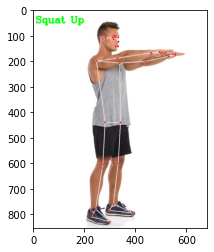

In [9]:
image = cv2.imread('./Test-Images/squat-up.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    label,color = classifyPose(landmarks, output_image, display=True)
    
    cv2.putText(output_image, label, (10, 50),cv2.FONT_HERSHEY_COMPLEX, 1.2, color, 3)
    

plt.imshow(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB))

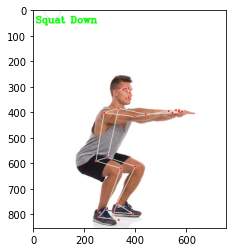

In [10]:
image = cv2.imread('./Test-Images/squat-down.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    label,color = classifyPose(landmarks, output_image, display=True)
    
    cv2.putText(output_image, label, (10, 50),cv2.FONT_HERSHEY_COMPLEX, 1.2, color, 3)
    

plt.imshow(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB))

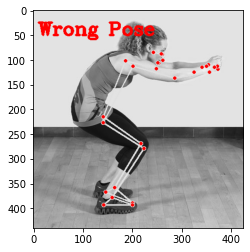

In [11]:
image = cv2.imread('./Test-Images/wrong-pose.jpg')
output_image, landmarks = detectPose(image, pose, display=False)
if landmarks:
    label,color = classifyPose(landmarks, output_image, display=True)
    
    cv2.putText(output_image, label, (10, 50),cv2.FONT_HERSHEY_COMPLEX, 1.2, color, 3)
    

plt.imshow(cv2.cvtColor(output_image,cv2.COLOR_BGR2RGB))

## Webcam | Video

In [8]:
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)
video = cv2.VideoCapture(0)

width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))


writer = cv2.VideoWriter('capture.mp4', cv2.VideoWriter_fourcc(*'XVID'),25, (width, height))

 
while video.isOpened():
    
    ok, frame = video.read()
    
    if not ok:
        break
        
    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ =  frame.shape
    frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
    
    frame, landmarks = detectPose(frame, pose_video, display=False)
    
    if landmarks:
        label,color = classifyPose(landmarks, frame, display=False)
        cv2.putText(frame, label, (10, 50),cv2.FONT_HERSHEY_COMPLEX, 1.2, color, 3)
    
    writer.write(frame)
    cv2.imshow('Pose Detection', frame)
    
  
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
video.release()
writer.release()
cv2.destroyAllWindows()